In [1]:
import Heston
import BlackScholes as bs
import arviz as az
import QuantLib as ql
import pandas as pd
import numpy as np
import copy
import datetime
import matplotlib.pyplot as plt
import risk_free_rates as rf
import implied_q as iq
import time
import pymc as pm
import pytensor.tensor as pt
import variance_curve as vc

from matplotlib import cm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Read the dataset

S0 = 4017.8

IV_df = pd.read_csv("hist_spx.csv")
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])
maturities = np.array(IV_df['Exp Date']).flatten()
IV = np.array(IV_df.drop(columns = 'Exp Date'))/100.

K = S0 * moneyness / 100

# Starting eta, kappa, theta, rho, sigma_0

#param = (0.0567259, 2.6604, 1.32985, -0.674692, 0.0440527)
eta,kappa,theta,rho,sigma_0 = (0.0567259, 2.6604, 1.32985, -0.674692, 0.0440527)

data = pd.read_csv("forward_var.csv")

In [3]:
tenors = np.array(data.TIME_MONTHS)/12
ask = np.array(data.ASK)
bid = np.array(data.BID)
true_vc = ((ask + bid)/2)*10

In [4]:
def f(rng, eta, kappa, sigma_0, size = None): 
    return np.sqrt(eta+(sigma_0-eta)*(1-np.exp(-kappa*tenors))/(kappa*tenors))*1000

In [5]:
s_t = time.time()
f(0, eta, kappa, sigma_0)
print(f'time: {time.time()-s_t: .2f}s')

time:  0.00s


In [6]:
start_time = time.time()

with pm.Model() as model_lv:
    eta = pm.Uniform("eta", lower = 1e-4, upper = 2)
    kappa = pm.Uniform("kappa", lower = 1, upper = 7)
    #theta = pm.Uniform("theta", lower = 0.5, upper = 3)
    #rho = pm.Uniform("rho", lower = -1, upper = -1e-4)
    sigma_0 = pm.Uniform("sigma_0", lower = 1e-4, upper = 2)

    sim = pm.Simulator("sim", f, params = (eta, kappa, sigma_0), observed = true_vc)

    idata_lv = pm.sample_smc(draws = 3000, progressbar=False)
    
print(f'Elapsed time: {time.time()-start_time: .2f}s')

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Elapsed time:  51.13s


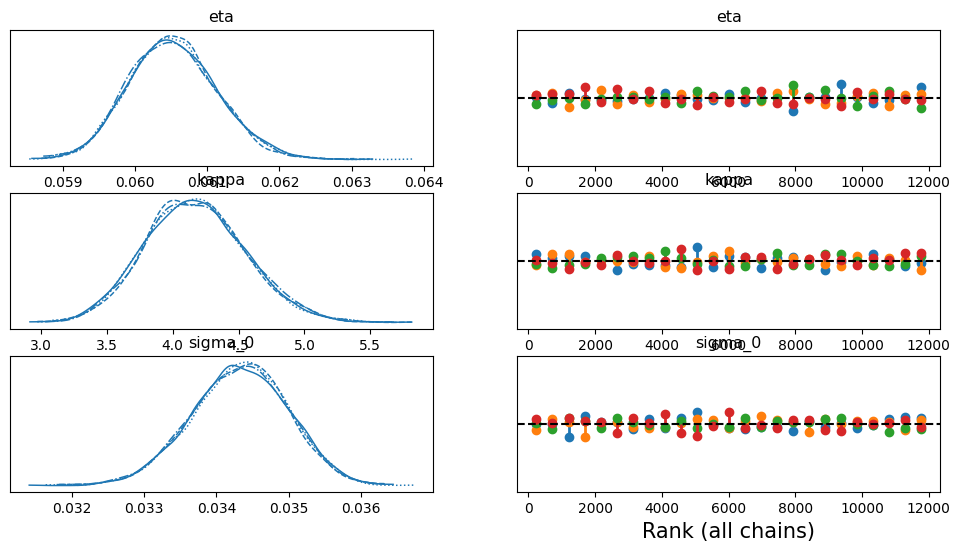

In [7]:
az.plot_trace(idata_lv, kind="rank_vlines");

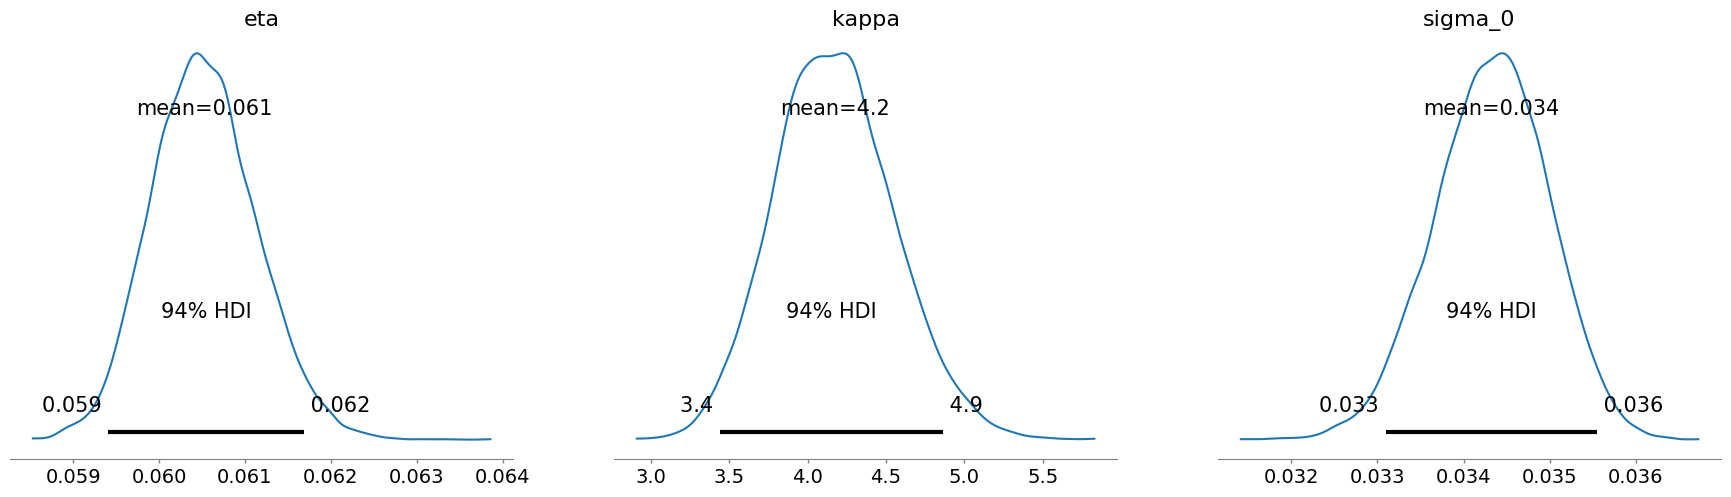

In [8]:
fig = az.plot_posterior(idata_lv);

In [9]:
eta = np.array(pd.DataFrame(idata_lv.posterior.eta)).flatten()
kappa = np.array(pd.DataFrame(idata_lv.posterior.kappa)).flatten()
sigma_0 = np.array(pd.DataFrame(idata_lv.posterior.sigma_0)).flatten()

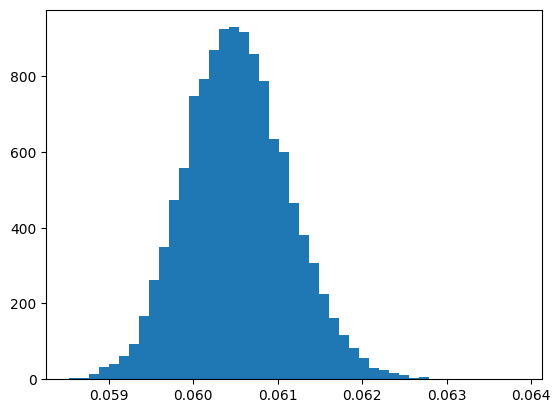

In [10]:
a = plt.hist(eta, bins = 45)

eta_x = (a[1][:-1] + a[1][1:])/2; eta_y = a[0]

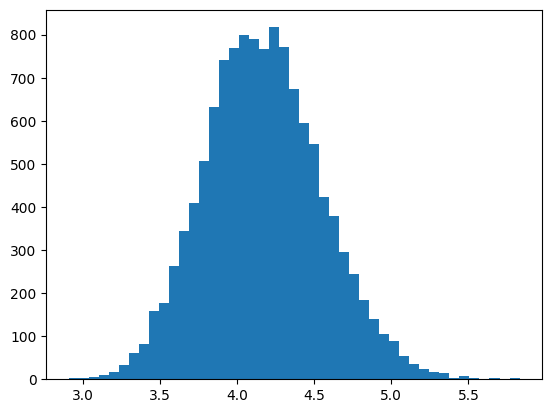

In [11]:
a = plt.hist(kappa, bins = 45)

kappa_x = (a[1][:-1] + a[1][1:])/2; kappa_y = a[0]

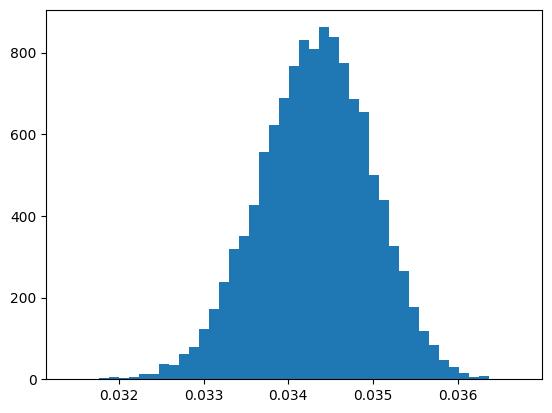

In [12]:
a = plt.hist(sigma_0, bins = 45)

sigma_0_x = (a[1][:-1] + a[1][1:])/2; sigma_0_y = a[0]

In [15]:
N = 64; L = 12;

r = rf.r(maturities)
n = len(maturities)
q = list()
for i in range(n):
    q.append(iq.q(maturities[i]))
q = np.array(q)

m = len(K)
options_type = np.ones(m)
price_matrix = np.zeros([n,m]); true_price = np.zeros([n,m]);
options_type[K > S0] = 0

for i in range(n):
    tau = maturities[i]
    for j in range(m):
        if j<5:
            true_price[i,j] = bs.BSCall(S0, K[j], tau, r[i], q[i], IV[i,j])
        else:
            true_price[i,j] = bs.BSPut(S0, K[j], tau, r[i], q[i], IV[i,j])
            
true_price = true_price.flatten()

true_iv = IV.flatten()*1000

In [16]:
def f(rng, eta, kappa, theta, rho, sigma_0, size = None):
    p = np.zeros(n*m)
    for i in range(n):
        tau = maturities[i]
        precomp_term, a, b = Heston.precomputed_terms(r[i], q[i], tau, sigma_0, kappa, eta, theta, rho, L, N)
        p[i*m:(i+1)*m] = Heston.cos_method_Heston_LF(precomp_term, a, b, tau, r[i], q[i], sigma_0, kappa, eta, theta, rho, 
                                       S0, K, N, options_type, L=12)
    return p

In [18]:
start_time = time.time()

with pm.Model() as model_lv:
    
    eta = pm.Interpolated("eta", eta_x, eta_y)
    kappa = pm.Interpolated("kappa", kappa_x, kappa_y)
    sigma_0 = pm.Interpolated("sigma_0", sigma_0_x, sigma_0_y)
    
    theta = pm.Uniform("theta", lower = 0.5, upper = 3)
    rho = pm.Uniform("rho", lower = -1, upper = -1e-4)

    sim = pm.Simulator("sim", f, params = (eta, kappa, theta, rho, sigma_0), epsilon = 10, observed = true_price)

    idata_lv = pm.sample_smc(draws = 500, chains = 4, progressbar=False)
    
print(f'Elapsed time: {time.time()-start_time: .2f}s')

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Elapsed time:  4142.26s


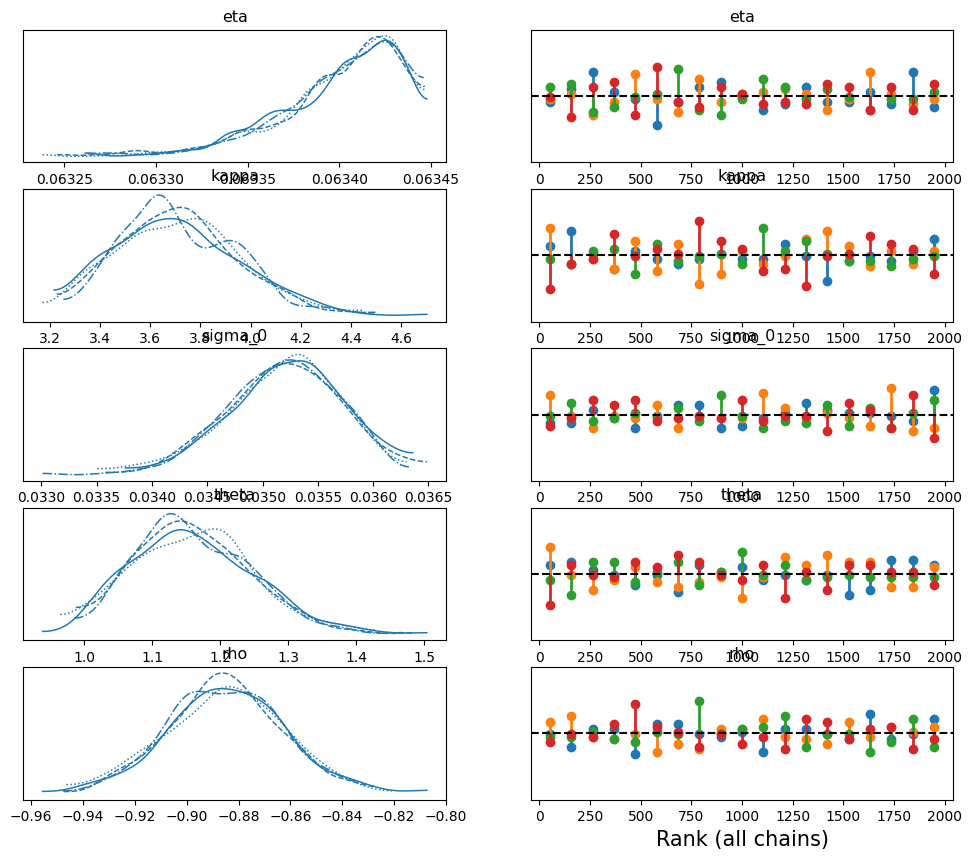

In [19]:
az.plot_trace(idata_lv, kind="rank_vlines");

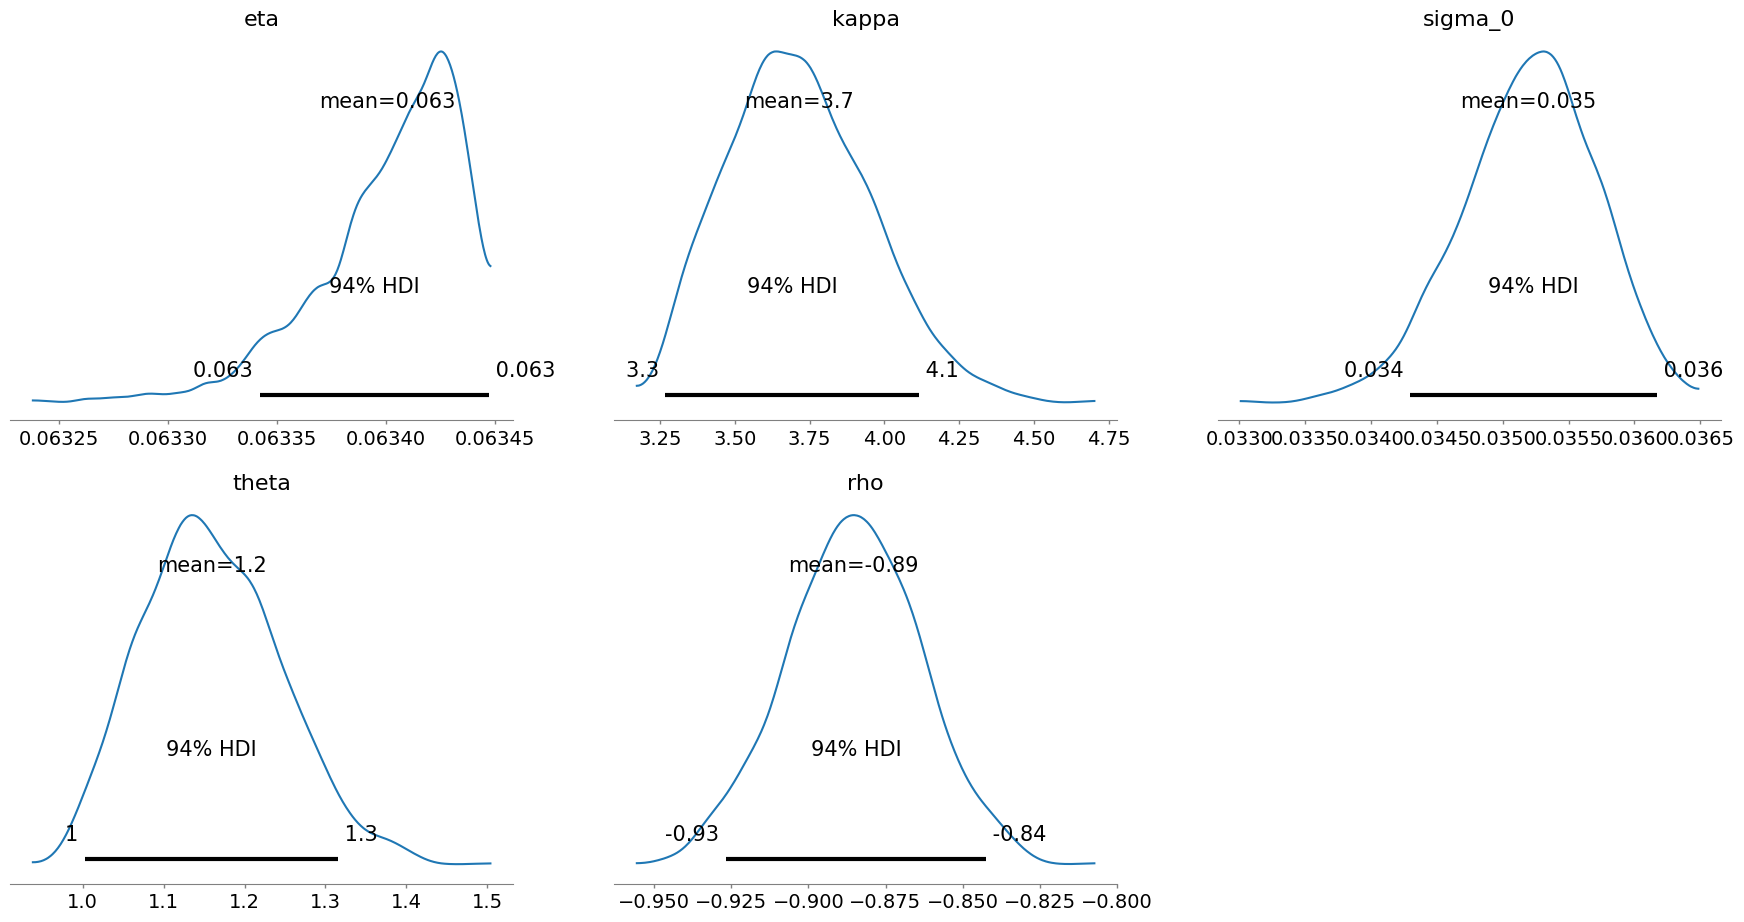

In [20]:
az.plot_posterior(idata_lv);

In [27]:
eta = np.array(pd.DataFrame(idata_lv.posterior.eta)).flatten()
kappa = np.array(pd.DataFrame(idata_lv.posterior.kappa)).flatten()
theta = np.array(pd.DataFrame(idata_lv.posterior.theta)).flatten()
rho = np.array(pd.DataFrame(idata_lv.posterior.rho)).flatten()
sigma_0 = np.array(pd.DataFrame(idata_lv.posterior.sigma_0)).flatten()

Eta: 0.06342414987390566


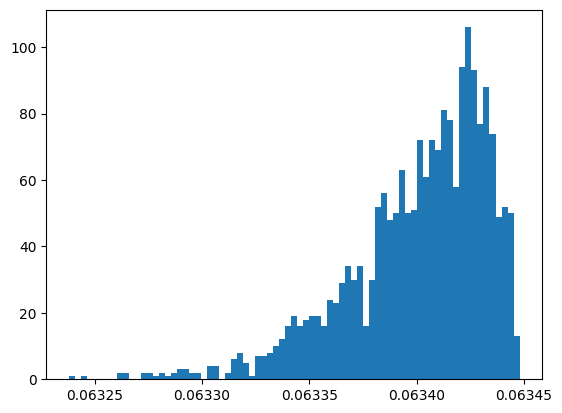

In [32]:
a = plt.hist(eta, bins = 75)

eta_x = (a[1][:-1] + a[1][1:])/2; eta_y = a[0]
eta_max = eta_x[np.argmax(eta_y)]
print("Eta:",eta_max)

Kappa: 3.7121224920811358


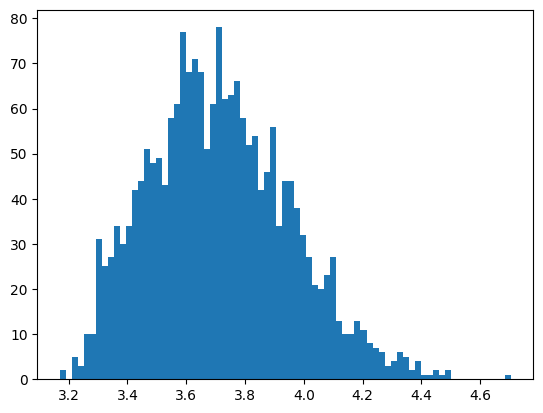

In [37]:
a = plt.hist(kappa, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
kappa_max = x[np.argmax(y)]
print("Kappa:",kappa_max)

Theta: 1.1229486908495434


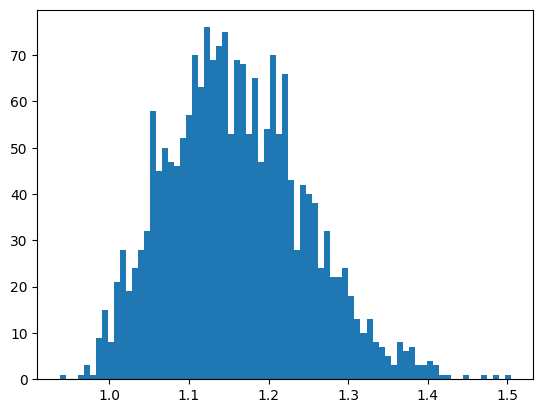

In [33]:
a = plt.hist(theta, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
theta_max = x[np.argmax(y)]
print("Theta:",theta_max)

Rho: -0.8814543930130166


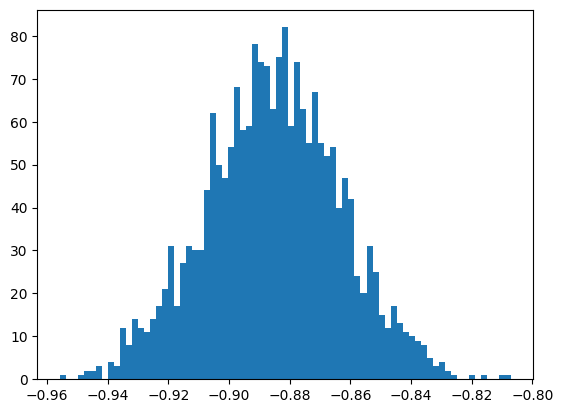

In [38]:
a = plt.hist(rho, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
rho_max = x[np.argmax(y)]
print("Rho:",rho_max)

Sigma: 0.035398273918840026


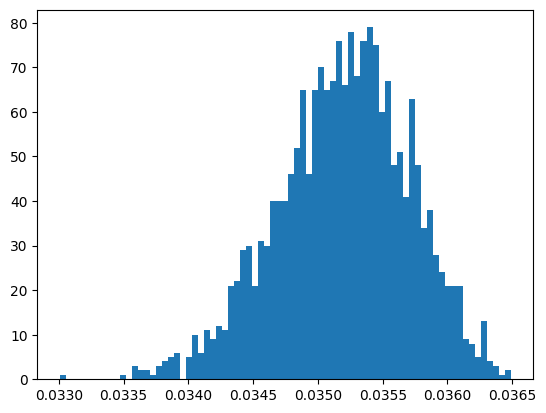

In [36]:
a = plt.hist(sigma_0, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
sigma_max = x[np.argmax(y)]
print("Sigma:",sigma_max)